In [1]:
import math
import numpy as np
import pandas as pd
from fun_utils import *
from scipy.optimize import minimize, least_squares
from scipy.optimize import fsolve
from scipy.integrate import quad
import matplotlib.pyplot as plt

In [2]:
## scenario switch
case=3;  # 2 means no trade in goods; 3 means trade in both energy and goods
logit = 0; # 1 means logit estimations of supply elasticity; 0 means fixed elasticities at 0.5

In [3]:
## parameter values
alpha = 0.85;           # labor share parameter in manufacturing
theta = 4;              # scopevec for comparative advantage
sigma = 1;      # elasticity of demand for each individual manufactured good j at Home
sigmastar = 1;  # elasticity of demand for each individual manufactured good j at Foreign
epsilonD = alpha + (1 - alpha) * sigma;  #Home's elasticity of demand for embodied energy
epsilonDstar = alpha + (1 - alpha) * sigmastar;  #Foreign's elasticity of demand for embodied energy
# beta = 2.274853;
# gamma= 0.784877595;
beta=1.892412;
gamma=0.807998928;
epsilonS = 0.5;  #Homes's energy supply elasticity: beta/(1 - beta)
epsilonSstar = 0.5;  #Foreign's energy supply elasticity: betastar/(1 - betastar)

In [4]:
ParaList = (alpha, theta, sigma, sigmastar, epsilonD,epsilonDstar, epsilonS,epsilonSstar, beta, gamma, logit)

In [5]:
tax_scenario= {'tax_sce': 'Unilateral', 'Base': 0}
df = {'Qe': 4.4800448, 'Qestar': 27.795946, 'Qeworld': 32.27599, 'CeHH': 4.598403, 'CeHF': 1.196111,'CeFH': 0.42160103,'CeFF': 26.059874,'Ce': 5.7945137,'Cestar': 26.481474,'Ge': 5.0200038,'Gestar': 27.255985,'Ceworld': 32.27599,'Geworld': 32.27599,'jxbar': 0.015920602214279298,'jmbar':  0.7935787194577492}

In [6]:
def opt_price(p, varphi, tax_scenario, ParaList, df):
    pe = p[0]
    tb_mat = p[1:]
    alpha, theta, sigma, sigmastar, epsilonD,epsilonDstar, epsilonS, epsilonSstar, beta, gamma, logit = ParaList

    #solve for equilibrium
    if tax_scenario['tax_sce']!='Unilateral':
        print("shouldn't be here")
        return 0
        
     ## optimal values
    # jxbar_hat =   (1 - df['jxbar']) ** (-1) / (((1 - df['jxbar']) ** (-1) - 1) + (1 + (1 - alpha) * tb_mat[0]/pe) ** (-theta) * (1 + tb_mat[0]/pe) ** ((1 - alpha) * theta));
    jxbar_hat = pe**(-alpha*theta) * (pe+tb_mat[0])**(-(1-alpha)*theta) / ( df['jxbar'] * pe**(-alpha*theta) * (pe+tb_mat[0])**(-(1-alpha)*theta) + (1-df['jxbar']) * (pe + (1-alpha) * tb_mat[0])**(-theta));
    j0_hat = (pe+tb_mat[0])**(-(1-alpha)*theta) / (df['jxbar'] * (pe+tb_mat[0])**(-(1-alpha)*theta) + (1-df['jxbar']) * pe**(-(1-alpha)*theta))
    jmbar_hat = 1
    
    if tax_scenario['tax_sce']=='Unilateral':
        te=varphi;

    
    jxbar_prime = jxbar_hat * df['jxbar'];
    jmbar_prime = jmbar_hat * df['jmbar'];
    
    j0_prime = j0_hat * df['jxbar'];

    def tempFunction(i, theta, sigmastar):
        return (i ** ((1 + theta) / theta - 1) * (1 - i) ** ((theta - sigmastar) / theta - 1)) 
    
    Bfunvec1_prime = quad(tempFunction,0,j0_prime, args=(theta, sigmastar))[0];
    Bfunvec2_prime = quad(tempFunction,0,jxbar_prime, args=(theta, sigmastar))[0];

    #if te is too large, Home stop producing
    petbte = pe + tb_mat[0] - te;
    z = pe + tb_mat[0] >= te;
    petbte = petbte * z;

    Qe_hat = (petbte) ** epsilonS;
    Qestar_hat = pe ** epsilonSstar;
          
    if logit==1:
        epsilonS=beta*(1-gamma)/(1-gamma+gamma*petbte**beta);
        epsilonSstar=beta*(1-gamma)/(1-gamma+gamma*pe**beta);
        Qe_hat = (petbte)**beta/(1-gamma+gamma*(petbte)**beta);
        Qestar_hat = pe**beta/(1-gamma+gamma*pe**beta);
 
    Qe_prime = df['Qe'] * Qe_hat;
    Qestar_prime = df['Qestar'] * Qestar_hat;
     
    CeHH_hat = (pe + tb_mat[0]) ** (-epsilonD) * jmbar_hat ** (1 + (1 - sigma)/theta);
    CeHH_prime = df['CeHH'] * CeHH_hat;
       
    
    # CeFH_hat = (1 + (1 - sigmastar)/theta) * pe ** (-(1 - alpha) * sigmastar) * (pe + tb_mat[0]) ** (-alpha) * Bfunvec_prime/(df['jxbar'] ** (1 +1/theta)) * (1 - df['jxbar']) ** (sigmastar/theta);
    CeFH1_hat = (pe +tb_mat[0])**(-epsilonDstar) * j0_hat**(1 + (1 - sigmastar)/theta);
    CeFH2_hat = (1 + (1 - sigmastar)/theta) * ((1-df['jxbar'])/df['jxbar'])**(sigmastar/theta) * pe**(-epsilonDstar) * (1 + tb_mat[0]/pe)**(-alpha) * (Bfunvec2_prime - Bfunvec1_prime)/df['jxbar']**(1+(1-sigmastar)/theta);
    CeFH1_prime = df['CeFH'] * CeFH1_hat;
    CeFH2_prime = df['CeFH'] * CeFH2_hat;
    CeFH_hat = CeFH1_hat + CeFH2_hat;
    
    if np.isnan(CeFH_hat)==True:
        CeFH_hat=0
    CeFH_prime =df['CeFH'] * CeFH_hat;
    
    
    CeHF_hat = (pe + tb_mat[0]) ** (-epsilonD);
    
    CeHF_prime = df['CeHF'] * CeHF_hat;
    
    
    CeFF_prime = df['CeFF'] * ((1 - jxbar_prime)/(1-df['jxbar'])) ** (1 + (1 - sigmastar)/theta) * pe ** (-epsilonDstar);
    
    ##
    VgHH = df['CeHH']/(1 - alpha);
    VgFF = df['CeFF']/(1 - alpha);
    
    VgFH = df['CeFH'] /(1 - alpha);
    # VgFH_prime = VgFH * pe ** ((1 - sigmastar) * (1 - alpha)) * (1 - (1 - jxbar_prime) ** (1 + (1 - sigmastar)/theta))/ (df['jxbar'] * (1 - df['jxbar']) ** ( (1-sigmastar)/theta));
    VgFH1_hat = (pe + tb_mat[0]) * CeFH1_hat;
    VgFH2_hat = pe**(1 - epsilonDstar) * ((1-j0_prime)**(1+(1-sigmastar)/theta) - (1-jxbar_prime)**(1+(1-sigmastar)/theta))/ (df['jxbar']  * (1 - df['jxbar'] )**( (1-sigmastar)/theta));
    VgFH1_prime = VgFH * VgFH1_hat;
    VgFH2_prime = VgFH * VgFH2_hat;
    
    
    diff = Qe_prime + Qestar_prime - (CeHH_prime + CeFH_prime + CeHF_prime + CeFF_prime);
    pai_g = (pe + tb_mat[0]) * CeFH2_prime / (1 - alpha) - VgFH2_prime
    
    numerator = varphi * epsilonSstar * Qestar_prime - sigmastar * (1-alpha) * pai_g
    denominator = epsilonSstar * Qestar_prime + epsilonDstar * CeFF_prime
    diff1 = tb_mat[0] * denominator - numerator
        
    return abs(diff) + abs(diff1)

In [7]:
varphi = 27.3

In [10]:
res1 = minimize(opt_price, (1, 10), args = (varphi, tax_scenario, ParaList, df), bounds = [(0,np.inf), (0, np.inf)], method = 'Nelder-Mead', options = {'maxfev': 10000})
res1

 final_simplex: (array([[0.90779309, 9.30731009],
       [0.90779039, 9.30728004],
       [0.90779116, 9.30729718]]), array([0.00015461, 0.00016399, 0.00018527]))
           fun: 0.00015461206924172188
       message: 'Optimization terminated successfully.'
          nfev: 108
           nit: 57
        status: 0
       success: True
             x: array([0.90779309, 9.30731009])

In [11]:
obj_val = verify([res1.x[1]], res1.x[0], varphi, tax_scenario, ParaList, df)
obj_val

(9.925589010961744e-05, -5.5356179132104444e-05)

In [146]:
def obj_eval(tax_scenario, ParaList, df):
    data = []
    for pe in np.arange(0,2,0.01):
        res1 = minimize(opt_price, (pe, 100), args = (varphi, tax_scenario, ParaList, df), bounds = [(0,np.inf), (0, np.inf)], method = 'Nelder-Mead', options = {'maxfev': 100000, 'maxiter': 10000})
        #print(res1)
        obj_val = verify([res1.x[1]], res1.x[0], varphi, tax_scenario, ParaList, df)
        data.append((pe, obj_val, res1.x[0], res1.x[1]))
    return data

In [147]:
data = obj_eval(tax_scenario, ParaList, df)

C:\Users\Alex\AppData\Local\Temp/ipykernel_22396/2572838797.py:13: RuntimeWarning: divide by zero encountered in double_scalars
  jxbar_hat = pe**(-alpha*theta) * (pe+tb_mat[0])**(-(1-alpha)*theta) / ( df['jxbar'] * pe**(-alpha*theta) * (pe+tb_mat[0])**(-(1-alpha)*theta) + (1-df['jxbar']) * (pe + (1-alpha) * tb_mat[0])**(-theta));
C:\Users\Alex\AppData\Local\Temp/ipykernel_22396/2572838797.py:13: RuntimeWarning: invalid value encountered in double_scalars
  jxbar_hat = pe**(-alpha*theta) * (pe+tb_mat[0])**(-(1-alpha)*theta) / ( df['jxbar'] * pe**(-alpha*theta) * (pe+tb_mat[0])**(-(1-alpha)*theta) + (1-df['jxbar']) * (pe + (1-alpha) * tb_mat[0])**(-theta));
C:\Users\Alex\AppData\Local\Temp/ipykernel_22396/2572838797.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  j0_hat = (pe+tb_mat[0])**(-(1-alpha)*theta) / (df['jxbar'] * (pe+tb_mat[0])**(-(1-alpha)*theta) + (1-df['jxbar']) * pe**(-(1-alpha)*theta))
C:\Users\Alex\AppData\Local\Temp/ipykernel_22396/2572838797.py:55

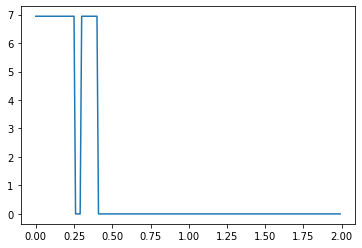

In [148]:
x_val = [x[0] for x in data]
#y_val = [x[1] for x in data]
z_val = [abs(x[1][0]) for x in data]
#plt.set_ylim(0, 2)
plt.plot(x_val,z_val)

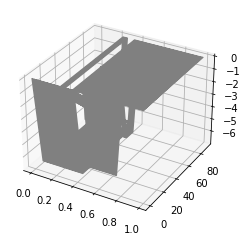

In [127]:
ax = plt.axes(projection='3d')
ax.plot3D(x_val, y_val, z_val, 'gray')

In [97]:
def integrand(i, a, b):
    return (i **(a-1)* (1 - i) ** ((b - 1))) 

In [103]:
quad(integrand,0,0.5, args=((1+theta)/theta, (theta-sigmastar)/theta))

(0.3669729873399108, 1.0975109709931985e-10)

In [105]:
def tempFunction(i, theta, sigmastar):
    return (i ** ((1 + theta) / theta - 1) * (1 - i) ** ((theta - sigmastar) / theta - 1)) 
    
quad(tempFunction,0,0.5, args=(theta, sigmastar))

(0.3669729873399108, 1.0975109709931985e-10)